# Example 2: Learning crystal energy 

#### Huan Tran

The main objective of this example is to get a small dataset of atomic crystal structures and their energy, fingerprint them, develop some ML models, and use these models to make predictions. 

### Plot with matplotlib, to be used latter

In [9]:
def plot_result():
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import r2_score

    print ('')
    print ('  Plot results in "training.csv" & "test.csv"')
    test_df=pd.read_csv('test.csv')
    train_df=pd.read_csv('training.csv')
    n_trains=len(train_df)
    n_tests=len(test_df)
    plt.figure(figsize=(6, 6))
    plt.rc('xtick', labelsize=13)
    plt.rc('ytick', labelsize=13)

    plt.xlim([-120,0])
    plt.xlim([-120,0])
    rmse_train = np.sqrt(np.mean((train_df['target']-train_df['md_target'])**2))
    r2_train = r2_score(train_df['target'],train_df['md_target'])
    rmse_test = np.sqrt(np.mean((test_df['target']-test_df['md_target'])**2))
    r2_test = r2_score(test_df['target'],test_df['md_target'])
    plt.text(-110,-35,'n_trains: %s points\nn_tests: %s points\ntraining rmse: %.3f (eV)\ntest rmse: %.3f (eV)\ntraining r2: %.3f (eV)\ntest r2: %.3f (eV)'
        %(n_trains,n_tests,rmse_train,rmse_test,r2_train,r2_test),size=11)

    plt.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True)
    plt.tick_params(axis='y',which='both',direction='in')
    plt.ylabel("Predicted value (eV)", size=14)
    plt.xlabel("Reference value (eV)", size = 14)
    plt.scatter(train_df['target'],train_df['md_target'],color='tab:red',alpha = 0.5,label='training set')
    plt.scatter(test_df['target'],test_df['md_target'],color='tab:blue',alpha = 0.5,label='testset')
    plt.legend(loc="lower right", fontsize = 13)
    plt.show()

### 1. Download data
The dataset contains 369 equilibrium structures of 13 different stouichiometries of Mg and Si, whose energy was computed using DFT. This dataset was reported in [T. D. Huan, Pressure-stabilized binary compounds of magnesium and silicon, Phys. Rev. Materials 2, 023803 (2018)]. It will now be obtained from www.matsml.org.

In [5]:
import os

# get data
data_url='https://www.matsml.org/data/PRM18_MgSi_structs.tgz'
os.system('wget -O PRM18_MgSi_structs.tgz --no-check-certificate '+data_url)
os.system('tar -xf PRM18_MgSi_structs.tgz')

# check necessary content
print (os.path.isfile('crystals/sum_list.csv'))

True


### 2. Fingerprint the obtained data
Some fingerprints will be used here for the obtained crystal dataset
1. Ewald sum matrix [Fe. Faber, A. Lindmaa, O. Anatole von Lilienfeld, and R. Armiento. <em>Crystal structure representations for machine learning models of formation energies</em> Int. J. Quantum Chem., 115, 1094 (2015)] is an analogy to the Coulomb matrix for molecules, and its size also depends on the number of atoms of the structure. We used a similar projection on a set of Gaussian. Keyword for this fingerprint is __psem_crystals__.
2. Matminer descriptors.

In [11]:
import pandas as pd
from matsml.fingerprint import Fingerprint

sum_list=os.path.join(os.getcwd(),'crystals/sum_list.csv')
data_loc=os.path.join(os.getcwd(),'crystals/')
n_atoms_max=28                         # Max number of atoms of the structures
fp_type='pesm_crystals'                # projected Ewald sum matrix for molecules
fp_file='fp_pesm.csv'                  # fingerprinted data file name
struct_format='poscar'                 # atomic structure format
fp_dim=100                             # intended fingerprint dimensionality
verbosity=0                            # verbosity, 0 or 1

data_params={'sum_list':sum_list,'data_loc':data_loc,'fp_file':fp_file,
    'struct_format':struct_format,'fp_type':fp_type,'fp_dim':fp_dim,
    'verbosity':verbosity,'n_atoms_max':n_atoms_max}

fp=Fingerprint(data_params)

# Compute fingerprint
fp.get_fingerprint()

# How does the fingerprinted data look like
print(pd.read_csv('fp_pesm.csv').columns)

  Atomic structure fingerprinting
    sum_list                     /home/huan/work/matsml/examples/ex2_crystals/crystals/sum_list.csv
    data_loc                     /home/huan/work/matsml/examples/ex2_crystals/crystals/
    n_atoms_max                  28
    struct_format                poscar
    fp_type                      pesm_crystals
    fp_dim                       100
    fp_file                      fp_pesm.csv
    verbosity                    0
  Read input
    num_structs                  329
  Computing Ewald sum Matrix
    [=                                                 ] 4%

/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


    [================================================= ] 100%
  Projecting Ewald sum matrix to create fingerprints
    [================================================= ] 100%
  Done fingerprinting, results saved in fp_pesm.csv
Index(['id', 'target', 'pesm_0000', 'pesm_0001', 'pesm_0002', 'pesm_0003',
       'pesm_0004', 'pesm_0005', 'pesm_0006', 'pesm_0007',
       ...
       'pesm_0090', 'pesm_0091', 'pesm_0092', 'pesm_0093', 'pesm_0094',
       'pesm_0095', 'pesm_0096', 'pesm_0097', 'pesm_0098', 'pesm_0099'],
      dtype='object', length=102)


<em>The fingerprinting step maybe a bit slow for a tutorial because we need to set at high enough max number of atoms to be 30. A version of fingerprinted data can also be obtained in case you want to skip this step.</em>

In [6]:
import os

# get data
fp_url='https://www.matsml.org/data/fp_PRM18_MgSi_structs.csv.gz'
os.system('wget -O fp_PRM18_MgSi_structs.csv.gz --no-check-certificate '+fp_url)

# check necessary content
print (os.path.isfile('fp_PRM18_MgSi_structs.csv.gz'))

True


### 3. Train some ML models

In [7]:
# data parameters for learning, note that this maybe different from data_params for the 
# above fingerprint step. We used the same data in "fp.csv" for all three algorithms below

#data_file = 'fp.csv'                      # comment out this line when skipping the fingerprinting step
data_file='fp_PRM18_MgSi_structs.csv.gz'   # use this line for fingerprint data from matsml.org  
id_col=['id']                              # this is id column in the fingerprint data
y_cols=['target']                          # this is y columns 
comment_cols=[]                            # other columns that are not id, not x, nor y columns
n_trains=0.85                              # 85% for training, 15% for validating
sampling='random'                          # way of train/test spliting. Random and more
x_scaling='minmax'                         
y_scaling='minmax'

data_params={'data_file':data_file, 'id_col':id_col,'y_cols':y_cols,
    'comment_cols':comment_cols,'y_scaling':y_scaling,'x_scaling':x_scaling,
    'sampling':sampling, 'n_trains':n_trains}

#### 3a. Fully-connected NeuralNet

 
  Learning fingerprinted/featured data
    algorithm                    fully connected NeuralNet w/ TensorFlow
    layers                       [8, 8]
    activ_funct                  tanh
    epochs                       300
    optimizer                    nadam
    nfold_cv                     5
  Reading data ... 
    data file                    fp_PRM18_MgSi_structs.csv.gz
    data size                    329
    training size                279 (84.8 %)
    test size                    50 (15.2 %)
    x dimensionality             100
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 FCNeuralNet
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.045732 0.092365 0.092365
    cv,rmse_train,rmse_test,rmse_opt: 1 0.030377 0.054201 0.054201
    cv,rmse_train,rmse_test,rmse_op

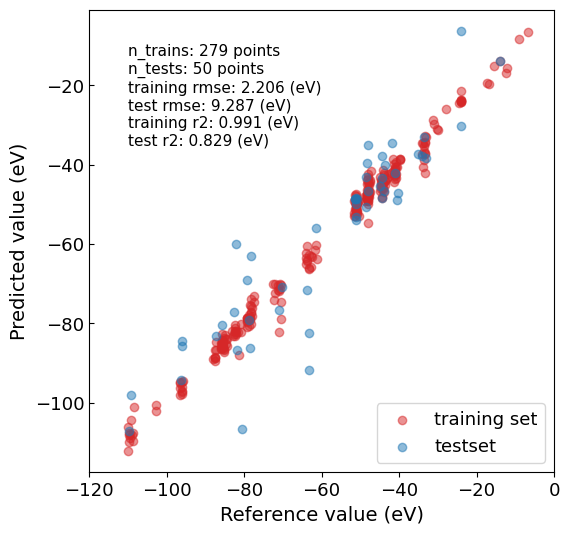

In [10]:
from matsml.models import FCNeuralNet

# Model parameters
layers=[8,8]                 # list of nodes in hidden layers
epochs=300                   # Epochs
nfold_cv=5                   # Number of folds for cross validation
use_bias=True                # Use bias term or not
model_file='model_nn.pkl'    # Name of the model file to be created
verbosity=0                  # Verbosity, 0 or 1
batch_size=32                # Default = 32
loss='mse'                   
metric='mse'
activ_funct='tanh'           # Options: "tanh","relu","sigmoid","softmax","softplus","softsign","selu","elu","exponential"
optimizer='nadam'            # options: "SGD","RMSprop","Adam","Adadelta","Adagrad","Adamax","Nadam","Ftrl"

model_params={'layers':layers,'activ_funct':activ_funct,'epochs':epochs,
    'nfold_cv':nfold_cv,'optimizer':optimizer,'use_bias':use_bias,
    'model_file':model_file,'loss':loss,'metric':metric,
    'batch_size':batch_size,'verbosity':verbosity,'rmse_cv':False}

# Compile a model
model=FCNeuralNet(data_params=data_params,model_params=model_params)

# Train the model
model.train()

# Plot results
plot_result()

#### 3b. KRR

 
  Learning fingerprinted/featured data
    algorithm                    kernel ridge regression w/ scikit-learn
    kernel                       rbf
    nfold_cv                     5
    alpha                        [-2, 5]
    gamma                        [-2, 5]
    number of alpha/gamma grids  10
  Checking parameters
  Reading data ... 
    data file                    fp_PRM18_MgSi_structs.csv.gz
    data size                    329
    training size                279 (84.8 %)
    test size                    50 (15.2 %)
    x dimensionality             100
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 KRR
  Training model w/ cross validation
  KRR model trained, now make predictions & invert scaling
    Unscaling y: minmax
       rmse training     target           5.561276
    Unscaling y: min

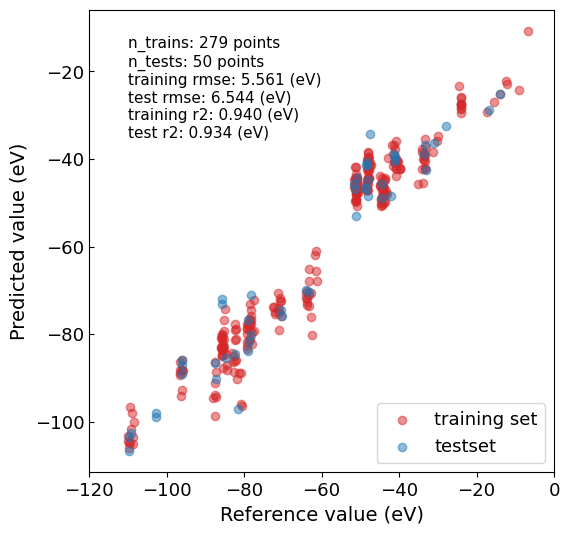

In [7]:
from matsml.models import KRR

# Model parameters
nfold_cv=5                     # Number of folds for cross validation
model_file='model_krr.pkl'         # Name of the model file to be created
metric = 'mse'                 #
alpha = [-2,5]
gamma = [-2,5]
n_grids = 10
kernel = 'rbf'

model_params={'kernel':kernel,'metric':metric,'nfold_cv':nfold_cv,
    'model_file':model_file,'alpha':alpha,'gamma':gamma,'n_grids':n_grids}

# Compile a model
model = KRR(data_params=data_params,model_params=model_params)

# Train the model
model.train()

# Plot results
plot_result()

#### 3c. GPR

 
  Learning fingerprinted/featured data
    algorithm                    gaussian process regression w/ scikit-learn
    nfold_cv                     5
  Checking parameters
  Reading data ... 
    data file                    fp_PRM18_MgSi_structs.csv.gz
    data size                    329
    training size                279 (84.8 %)
    test size                    50 (15.2 %)
    x dimensionality             100
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
  Scaling y                      minmax
  Prepare train/test sets        random
  Training model w/ cross validation


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.00632335720443479. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 0 0.054882 0.059474 0.059474
    Unscaling y: minmax
       rmse cv_test      target           6.136232


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.00632335720443479. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 1 0.053971 0.069504 0.059474
    Unscaling y: minmax
       rmse cv_test      target           7.170991


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.00632335720443479. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 2 0.055088 0.064876 0.059474
    Unscaling y: minmax
       rmse cv_test      target           6.693525


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.00632335720443479. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 3 0.054673 0.071951 0.059474
    Unscaling y: minmax
       rmse cv_test      target           7.423476


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.00632335720443479. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 4 0.055818 0.073570 0.059474
    Unscaling y: minmax
       rmse cv_test      target           7.590561
  GPR model trained, now make predictions & invert scaling
    Unscaling y: minmax
       rmse training     target           5.884648
    Unscaling y: minmax
       rmse test         target           6.903885
  Predictions made & saved in "training.csv" & "test.csv"

  Plot results in "training.csv" & "test.csv"


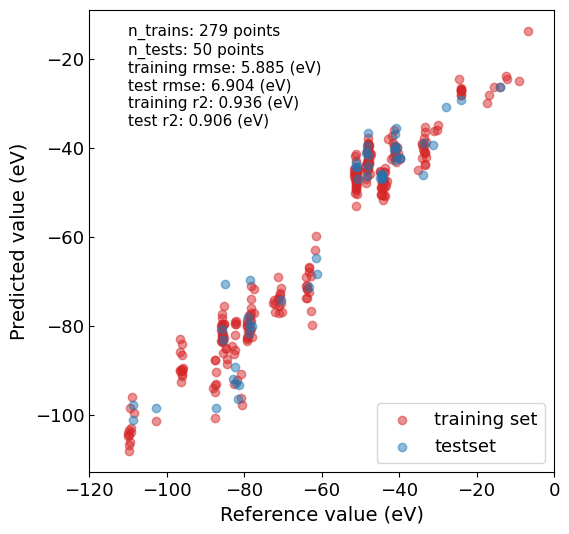

In [8]:
from matsml.models import GPR

# Model parameters
nfold_cv=5                     # Number of folds for cross validation
model_file='model_gpr.pkl'         # Name of the model file to be created
verbosity=0
rmse_cv=True
n_restarts_optimizer=100

model_params={'metric':metric,'nfold_cv':nfold_cv,
        'n_restarts_optimizer':n_restarts_optimizer,
        'model_file':model_file,'verbosity':verbosity,'rmse_cv':rmse_cv}

# Compile a model
model=GPR(data_params=data_params,model_params=model_params)

# Train the model
model.train()

# Plot results
plot_result()